# Overview

The goal of this notebook is to implement Delta Method for constructing Confidence Intervals (variance estimation) for ratio metrics, which is presendted in details in this paper [Applying the Delta Method in Metric Analytics: A Practical Guide with Novel Ideas](https://alexdeng.github.io/public/files/kdd2018-dm.pdf). We will also study the Numerical examples included in the paper.



# Problem 1 - Relative Difference or Percent Change
Let $X_1, X_2, ...X_n$ be i.i.d. observations from the control group with mean $\mu_x$ and variance $\sigma^2_x$, $Y_1, Y_2, ...Y_n$ be i.i.d. observations from the treatment group with mean $\mu_y$ and variance $\sigma^2_y$

Let absolute difference be $\hat{\Delta} = \bar{Y}-\bar{X}$, then we know 
$$Var(\hat{\Delta} ) = (\sigma^2_y+\sigma^2_x-2\sigma_{xy})/n .$$

The 100(1-$\alpha$)\% confidence interval of $\Delta$ is $\hat{\Delta} \pm z_{\alpha} \times \widehat{Var}(\hat{\Delta})$, where  $\widehat{Var}(\hat{\Delta}) = (s_y^2 + s_x^2 - 2s_{xy})/n$

Let relative difference (scale-invariant) be $\hat{\Delta}\% = (\bar{Y}-\bar{X})/\bar{X}$, the problem is contructing a 100(1-$\alpha$)\% confidence interval for  $\hat{\Delta}\%$

# Solution: Delta Method

$$\frac{\bar{Y}}{\bar{X}} - 1 \pm \frac{z_{\alpha/2}}{\sqrt{n}\bar{X}} \sqrt{s_y^2 - 2\frac{\bar{Y}}{\bar{X}}s_{xy} + \frac{\bar{Y}^2}{\bar{X}^2}s_x^2  },$$
Where $\frac{\bar{Y}}{\bar{X}} - 1$ is the point estimate, and a second-order bias correction term

$$\frac{\bar{Y}s_x^2/\bar{X} - s_{xy}}{(n\bar{X})^2} = \bar{Y}/\bar{X}^3 \times s_x^2/n - 1/\bar{X}^2 \times s_{xy}/n$$

should also be added to the point estimate
# 

# Python Implementation

In [88]:
import numpy as np
from scipy.stats import norm

def relative_diff_var_est(x, y, alpha=0.05):
    n = len(x)
    
    x_bar = np.mean(x)
    y_bar = np.mean(y)
    
    s2_x = np.var(x)
    s2_y = np.var(y)
    s_xy = np.cov(x, y)[1,1]
    
    bias_correction = y_bar/x_bar**3 * s2_x/n - 1/x_bar^2 * s_xy/n
    
    point_est = y_bar/x_bar - 1 + bias_correction
    
    var_est = s2_y/x_bar**2 - 2 * (y_bar/x_bar**3) * s_xy + (y_bar**2/x_bar**4) * s2_X
    
    return var_est

def relative_diff_ci(x, y, alpha=0.05):
    n = len(x)
    
    x_bar = np.mean(x)
    y_bar = np.mean(y)
    
    s2_x = np.var(x)
    s2_y = np.var(y)
    s_xy = np.cov(x, y)[0,1]

    bias_correction = y_bar/x_bar**3 * s2_x/n - 1/x_bar**2 * s_xy/n
    
    point_est = y_bar/x_bar - 1 + bias_correction
    
    var_est = s2_y/x_bar**2 - 2 * (y_bar/x_bar**3) * s_xy + (y_bar**2/x_bar**4) * s2_x
    
    ci_lower = point_est - norm.ppf(1-alpha/2) * np.sqrt(var_est/n)
    
    ci_upper = point_est + norm.ppf(1-alpha/2) * np.sqrt(var_est/n)
    
    return ci_lower, ci_upper
    

# Numerical Examples

$X_i \sim N(1, 0.1), Y_i \sim N(1.1, 0.1)$

$\Delta = 10\%$

In [109]:
sample_sizes = [50, 200, 2000, 2500, 5000, 10000, 20000]

In [110]:
coverage_rates = []
true_relative_diff = 0.1
for size in sample_sizes:
    data_temp = []
    for i in range(10000):
        x = np.random.normal(1, 0.1, size)
        y = np.random.normal(1.1, 0.1, size)
        ci_lower, ci_upper = relative_diff_ci(x,y)
        covered = ci_lower <= true_relative_diff and ci_upper >= true_relative_diff
        data_temp.append(covered)
    coverage_rates.append(np.mean(data_temp))


In [111]:
data = pd.DataFrame({"sample_size":sample_sizes, "coverage_rate": coverage_rates})

In [112]:
data

,sample_size,coverage_rate
0,50,0.9431
1,200,0.9503
2,2000,0.9516
3,2500,0.9494
4,5000,0.9472
5,10000,0.9496
6,20000,0.9512


$X_i \sim Ber(0.5), Y_i \sim Ber(0.6)$

$\Delta = 20\%$

In [115]:
sample_sizes = [50, 200, 2000, 2500, 5000, 10000, 20000]
coverage_rates = []
true_relative_diff = 0.2
for size in sample_sizes:
    data_temp = []
    for i in range(10000):
        x = np.random.binomial(1, 0.5, size)
        y = np.random.binomial(1, 0.6, size)
        ci_lower, ci_upper = relative_diff_ci(x,y)
        covered = ci_lower <= true_relative_diff and ci_upper >= true_relative_diff
        data_temp.append(covered)
    coverage_rates.append(np.mean(data_temp))


In [116]:
data = pd.DataFrame({"sample_size":sample_sizes, "coverage_rate": coverage_rates})

In [117]:
data

,sample_size,coverage_rate
0,50,0.9441
1,200,0.9511
2,2000,0.9458
3,2500,0.9510
4,5000,0.9481
5,10000,0.9535
6,20000,0.9512


# Problem 2 - Cluster Randomization
Two concepts:
- Randomizaiton unit: the granularity level where sampling or randomization is performed
- Analysis unit: the aggregation level of metric computation

Many important metrics come from the ratio of two metrics. For example
$$click-through \  rate = \frac{total \ clicks}{total \ pageviews} = \frac{total \ clicks\ /\ \#\ users}{total \ pageviews\ /\ \#\ users} = \frac{clicks\ per\ user}{pageviews\ per\ user},$$
\
$$revenue\ per\ click = \frac{total \ revenue}{total \ clicks} = \frac{total \ revenue\ /\ \#\ users}{total \ clicks\ /\ \#\ users} = \frac{revenue\ per\ user}{clicks\ per\ user},$$


the analysis unit is no longer a user, but a pageview or a click, when the experiment is randomized by the unit of a user, this can create challenge for estimating variance and constructing confidence intervals.

Suppose there are $K$ clusters (users) in treatment group. For $i=1,...,K$, the $i$th cluster contains $N_i$ analysis unit level observations $Y_{ij}$, $j=1,...,N_i$, the metric we are interested in is $\bar{Y} = \Sigma_{i,j} Y_{ij}/\Sigma_iN_i$. Usually for $i$th cluster(user), $Y_{i1}, ... Y_{iN_i}$ are correlated (within user correlation), which is why we can't directly apply traditional sample variance formula to estimate variance where ovservations are independent.


# Solution
Re-write $\bar{Y}$ into $\Sigma_i(\Sigma_jY_{ij})/\Sigma N_i$, let $S_i = \Sigma_jY_{ij}$ and divide both the numerator and denominator by $K$,

$$\bar{Y} = \frac{\Sigma_iS_i/K}{\Sigma_iN_i/K} =\frac{\bar{S}}{\bar{N}},$$

then based on previous results we have

$$Var(\bar{Y}) = Var(\frac{\bar{S}}{\bar{N}} ) = \frac{1}{K\mu_N^2} (\, \sigma_S^2 - 2\frac{\mu_S}{\mu_N}\sigma_{SN} + \frac{\mu_S^2}{\mu_N^2}\sigma_N^2  )$$

- Both the variance of the cluster size $N_i$ and variance of the within-cluster sum of observations $S_i$, contribute to $Var(\bar{Y})$
- $\sigma_N^2$ is an important contributor, so it's desirable to make the cluster sizs homogeneous, otherwise small treatment effect is difficult to detest due to large variance (low statistical power).

# Numerical Examples

K = 1000
$$(M_1, M_2, M_3) \sim Multi-nomial\{n=K; p=(1/3, 1/2, 1/6)\}$$

For the ith cluster (user), we have:
- Small: $N_i \sim Poisson(2)$, $\mu_i \sim N(0.3, 0.05)$
- Medium: $N_i \sim Poisson(5)$, $\mu_i \sim N(0.5, 0.1)$
- Large: $N_i \sim Poisson(30)$, $\mu_i \sim N(0.8, 0.05).$

Then, for each fixed $i$, let $Y_{ij} \sim Bernoulli(p=\mu_i)$ for all $j = 1, ..., N_i$, then we know $S_i | N_i \sim Binomial(N_i, \mu_i)$

In [171]:
M_list = list(np.random.multinomial(1000, [1/3, 1/2, 1/6], size=1)[0])

In [221]:
data_mean = []
data_std = []
for d in range(20):
    obs = []
    M_list = list(np.random.multinomial(1000, [1/3, 1/2, 1/6], size=1)[0])
    for M in M_list:
        c = M_list.index(M)
        for i in range(M):
            mu_i = -1
            while mu_i < 0 or mu_i > 1:
                if c == 0:
                    n_i = np.random.poisson(2, 1) 
                    mu_i = np.random.normal(0.3, np.sqrt(0.05), 1)
                elif c == 1:
                    n_i = np.random.poisson(5, 1) 
                    mu_i = np.random.normal(0.5, np.sqrt(0.1), 1)
                else:
                    n_i = np.random.poisson(30, 1) 
                    mu_i = np.random.normal(0.8, np.sqrt(0.05), 1)

            y_i = np.random.binomial(1, mu_i, n_i)
            obs+=list(y_i)
    data_mean.append(np.mean(obs))
    data_std.append(np.std(obs)/np.sqrt(len(obs)))

In [222]:
len(data_std)

20

In [223]:
np.mean(data_std)

0.005373516479861186

In [224]:
np.mean(data_mean)

0.6272364457815089

In [220]:
np.std(data_mean)

0.012497538275029887

In [194]:
len(data_mean)

888

In [161]:
np.mean(obs)

0.6730033476805356

In [163]:
np.var(obs)/len(obs)

2.6311554482463853e-05

In [167]:
np.std(obs)/np.sqrt(len(obs))

0.005129478967932694

In [122]:
k1 = 333
k2 = 500
k3 = 167

In [123]:
k1+k2+k3

1000

In [124]:
0.3*0.7 * 333 + 0.5*0.5*500 + 0.8*0.2*167

221.65

In [125]:
mu_s = 2*0.3* (1/3) + 5*0.5*0.5 + 30*0.8*1/6

In [126]:
mu_s 

5.45

In [1]:
import numpy as np

In [305]:
a = 0
b = 0.2

In [439]:
y = np.random.normal(0, 1, 1000)

In [440]:
rho = np.sqrt(1-0.8**2)

In [441]:
rho

0.5999999999999999

In [442]:
#y_hat = np.random.normal(rho*y, np.sqrt(1-rho**2), 1000)
y_hat = 0.59 * y + np.random.normal(0,0.5, 1000)

In [56]:
from matplotlib import pyplot as plt

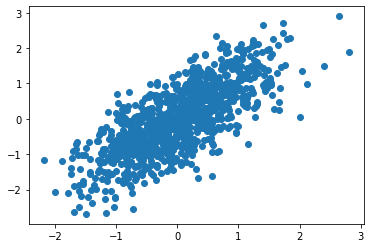

In [444]:
plt.scatter(y_hat,y)

In [44]:
from scipy.stats import pearsonr

In [446]:
pearsonr(y , y_hat)

(0.7500946852834101, 2.016021075797223e-181)

In [430]:
x = y_hat/0.2+ np.random.normal(0,1, 1000)

In [43]:
import statsmodels.api as sm

In [432]:
x = sm.add_constant(x, prepend=False)

In [433]:
y = sm.add_constant(y, prepend=False)

In [434]:
mod = sm.OLS(y_hat,y)
res = mod.fit()

In [435]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 8.194e+05
Date:                Fri, 28 May 2021   Prob (F-statistic):               0.00
Time:                        19:17:28   Log-Likelihood:                 2455.2
No. Observations:                1000   AIC:                            -4906.
Df Residuals:                     998   BIC:                            -4897.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5896      0.001    905.218      0.0

In [364]:
mod = sm.OLS(y_hat,x)
res = mod.fit()

In [365]:
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.968
Model:                            OLS   Adj. R-squared (uncentered):              0.968
Method:                 Least Squares   F-statistic:                          2.980e+04
Date:                Fri, 28 May 2021   Prob (F-statistic):                        0.00
Time:                        19:05:36   Log-Likelihood:                          213.23
No. Observations:                1000   AIC:                                     -424.5
Df Residuals:                     999   BIC:                                     -419.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [297]:
sum((y-y_hat)**2)/np.var(y)

830.5819592436072

In [45]:
x =  np.random.normal(10, 1, 1000)

In [46]:
y = 0.3 * x + np.random.normal(0,0.08,1000)

In [47]:
0.05496396275234286**2

0.0030210372014409332

In [48]:
x = sm.add_constant(x)
mod = sm.OLS(y,x)
res = mod.fit()

In [51]:
res.rsquared

0.9258229489989425

In [529]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                 1.423e+04
Date:                Sat, 29 May 2021   Prob (F-statistic):               0.00
Time:                        10:17:42   Log-Likelihood:                 1109.4
No. Observations:                1000   AIC:                            -2215.
Df Residuals:                     998   BIC:                            -2205.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0024      0.025     -0.093      0.9

In [25]:
y = np.random.normal(0, np.sqrt(0.4), 1000)

In [26]:
e = np.random.normal(0, np.sqrt(0.4), 1000)

In [27]:
y_hat = y-e

In [28]:
np.var(y_hat)

0.7359728948295668

In [29]:
np.var(y-y_hat)

0.3950135487656449

In [123]:
x =np.random.normal(0, 1, 1000)

In [134]:
rsquared_list = []
res_var_list = []
for i in np.arange(0, 1, 0.01):
    y = 0.2*x + np.random.normal(0, i, 1000)
    xx = sm.add_constant(x)
    mod = sm.OLS(y,xx)
    res = mod.fit()
    rsquared_list.append(res.rsquared)
    res_var_list.append(np.var(res.resid))
    #print(res.rsquared)

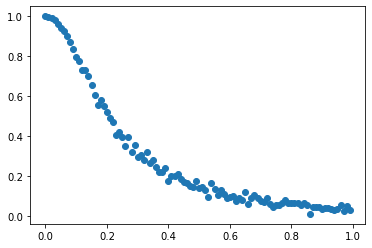

In [135]:
plt.scatter( np.arange(0, 1, 0.01),rsquared_list)

In [136]:
np.min(np.abs(np.array(rsquared_list)-0.8))

0.005214311462100385

In [137]:
el = list(np.abs(np.array(rsquared_list)-0.8))

In [138]:
el.index(np.min(np.abs(np.array(rsquared_list)-0.8)))

10

In [139]:
np.arange(0, 1, 0.01)[10]

0.1

In [ ]:
x =np.random.normal(0, 1, 1000)

In [177]:
beta = 0.2
x_var = 10
s = beta**2*x_var/0.8 * 0.2

In [178]:
x =np.random.normal(0, np.sqrt(x_var), 1000)

In [179]:
y = beta*x + np.random.normal(0, np.sqrt(s), 1000)
xx = sm.add_constant(x)
mod = sm.OLS(y,xx)
res = mod.fit()

In [180]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     3801.
Date:                Sat, 29 May 2021   Prob (F-statistic):               0.00
Time:                        13:26:14   Log-Likelihood:                -267.85
No. Observations:                1000   AIC:                             539.7
Df Residuals:                     998   BIC:                             549.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0127      0.010      1.273      0.203      -0.007       0.032
x1             0.1992      0.003     61.655      0.000       0.193       0.206
==============================================================================
Omnibus:                        0.573   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.751   Jarque-Bera (JB):                0.653
Skew:                           0.047   Prob(JB):                        0.722
Kurtosis:                       2.917   Cond. No.                         3.10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

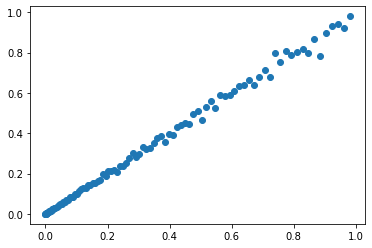

In [74]:
plt.scatter( np.arange(0, 1, 0.01)**2,res_var_list)

In [161]:
x = np.random.normal(0, 1, 1000)
e = np.random.normal(0, np.sqrt(0.2*0.04/0.8), 1000)
y = 0.2*x + e
xx = sm.add_constant(x)
mod = sm.OLS(y,xx)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     3610.
Date:                Sat, 29 May 2021   Prob (F-statistic):               0.00
Time:                        13:20:08   Log-Likelihood:                 874.66
No. Observations:                1000   AIC:                            -1745.
Df Residuals:                     998   BIC:                            -1735.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.176e-05      0.003     -0.007      0.9

In [106]:
0.04/0.8

0.049999999999999996

In [107]:
np.var(y)

0.042125886036085414

In [108]:
np.var(res.resid)

0.002064377709247821

In [109]:
np.var(res.resid)/np.var(y)

0.04900496828670753